# 1.Tải dữ liệu

## 1.1.Import dữ liệu

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import tabulate
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer

## 1.2.Tải và phân tích dữ liệu

In [3]:

column_names = ['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 
                'compactness_mean', 'concavity_mean', 'concave_points_mean', 'symmetry_mean', 'fractal_dimension_mean', 
                'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 
                'concave_points_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst', 
                'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 
                'concave_points_worst', 'symmetry_worst', 'fractal_dimension_worst']

data = pd.read_csv("data/Binary.csv",names=column_names,delimiter=',')
print(data.head())
print(data.info())

         id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave_points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   ...  radius_worst  texture_worst  perimeter_worst  area_wor

# 2.Các bước thực hiện

## 2.1.Chuẩn bị dữ liệu 

### 2.1.1.Tách dữ liệu thành đặc trưng (feature) và nhãn (labels)

In [4]:
data.replace('?', np.nan, inplace=True)  # Thay thế giá trị '?' bằng NaN
imputer = SimpleImputer(strategy='mean')  # Using mean imputation for missing values
data_imputed = data.copy()
data_imputed.iloc[:, 2:] = imputer.fit_transform(data.iloc[:, 2:])  # Impute only the features, not the id/diagnosis columns

# Encode the diagnosis column: 'M' -> 1, 'B' -> 0
label_encoder = LabelEncoder() #chuyển đổi các nhãn thành dang số nguyên(integer)
data_imputed['diagnosis'] = label_encoder.fit_transform(data_imputed['diagnosis'])

# Split the dataset into features (X) and labels (y)
X = data_imputed.iloc[:, 2:]  # Features (all columns except id and diagnosis)
y = data_imputed['diagnosis']  # Labels (diagnosis)

print(y)
print(X)


0      1
1      1
2      1
3      1
4      1
      ..
564    1
565    1
566    1
567    1
568    0
Name: diagnosis, Length: 569, dtype: int64
     radius_mean  texture_mean  perimeter_mean  area_mean  smoothness_mean  \
0          17.99         10.38          122.80     1001.0          0.11840   
1          20.57         17.77          132.90     1326.0          0.08474   
2          19.69         21.25          130.00     1203.0          0.10960   
3          11.42         20.38           77.58      386.1          0.14250   
4          20.29         14.34          135.10     1297.0          0.10030   
..           ...           ...             ...        ...              ...   
564        21.56         22.39          142.00     1479.0          0.11100   
565        20.13         28.25          131.20     1261.0          0.09780   
566        16.60         28.08          108.30      858.1          0.08455   
567        20.60         29.33          140.10     1265.0          0.11780   


### 2.1.2.Phân tích dữ liệu gốc

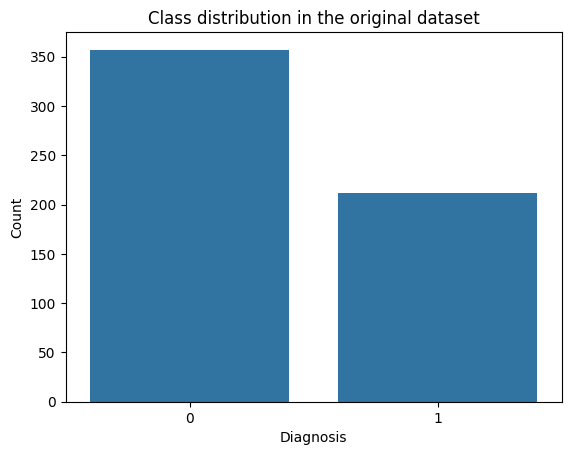

In [5]:
# Phân phối lớp trong tập dữ liệu
sns.countplot(x=y)
plt.title('Class distribution in the original dataset')
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.show()

### 2.1.3.Phân chia dữ liệu train/test với các tỉ lệ khác nhau

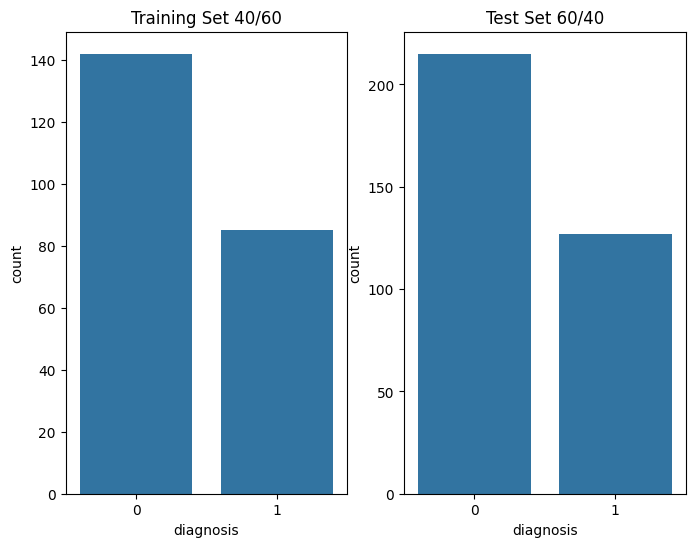

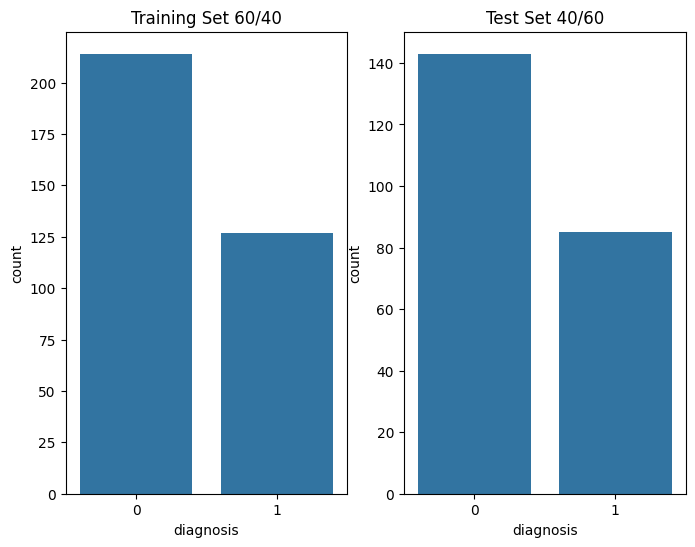

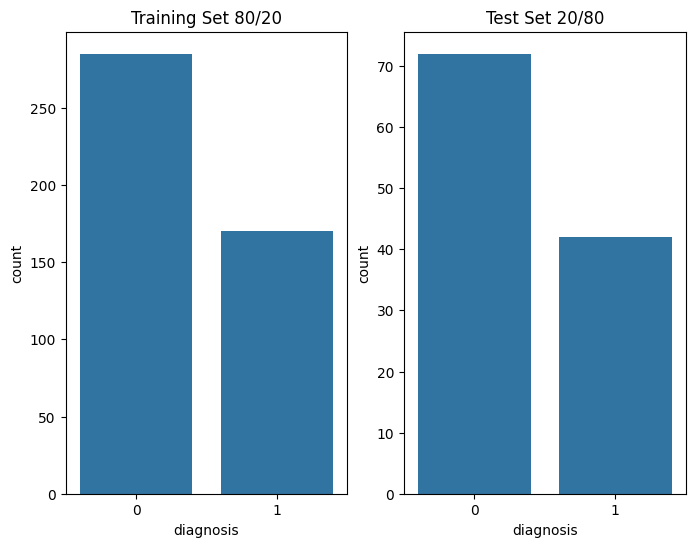

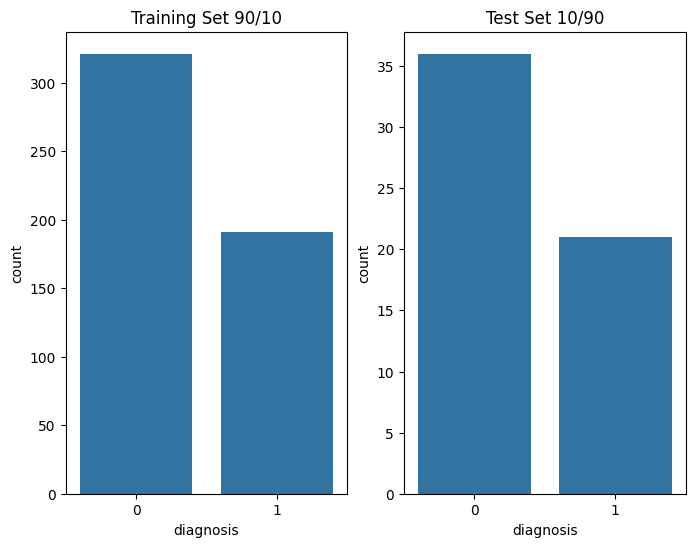

In [6]:
# các tỷ lệ (train_size, test_size)
splits = [(0.4, 0.6), (0.6, 0.4), (0.8, 0.2), (0.9, 0.1)]
datasets = {}

for train_size, test_size in splits:
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, test_size=test_size, stratify=y, random_state=42)
    datasets[(train_size, test_size)] = (X_train, X_test, y_train, y_test)
    
    # Visualize the class distribution for each split
    fig, ax = plt.subplots(1, 2, figsize=(8, 6))
    sns.countplot(x=y_train, ax=ax[0])
    sns.countplot(x=y_test, ax=ax[1])
    ax[0].set_title(f'Training Set {int(train_size*100)}/{int(test_size*100)}')
    ax[1].set_title(f'Test Set {int(test_size*100)}/{int(train_size*100)}')
    plt.show()

## 2.2.Xây dựng bộ phân loại cây quyết định và trực quan hóa cây

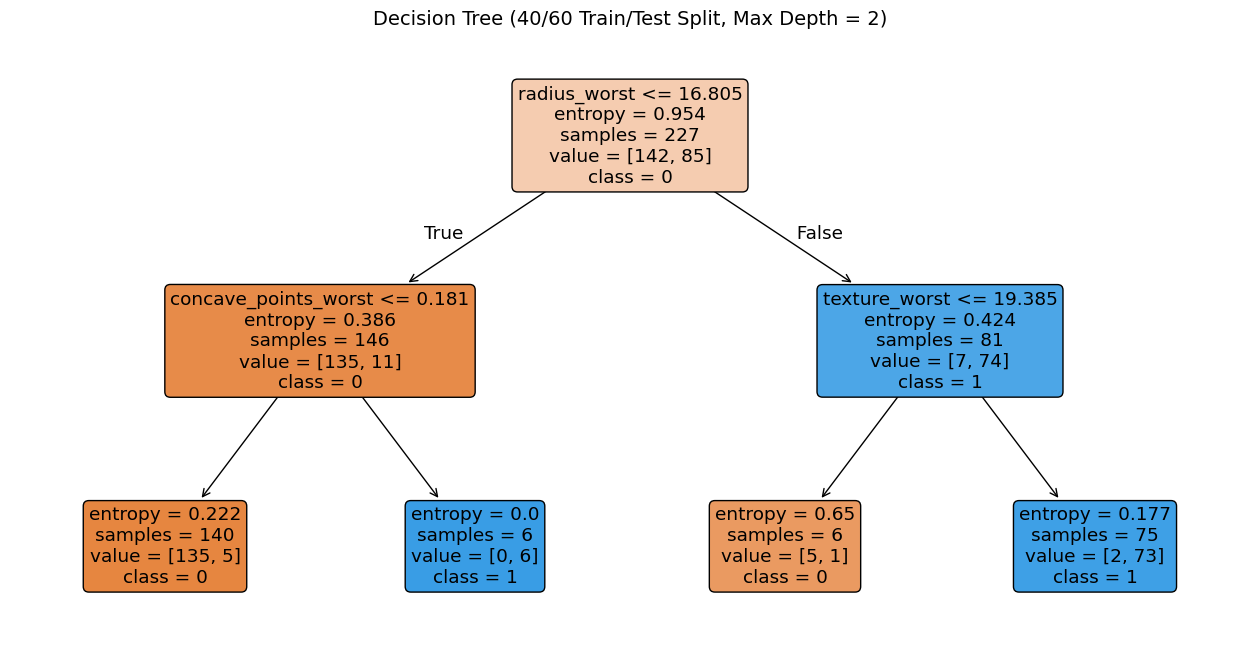

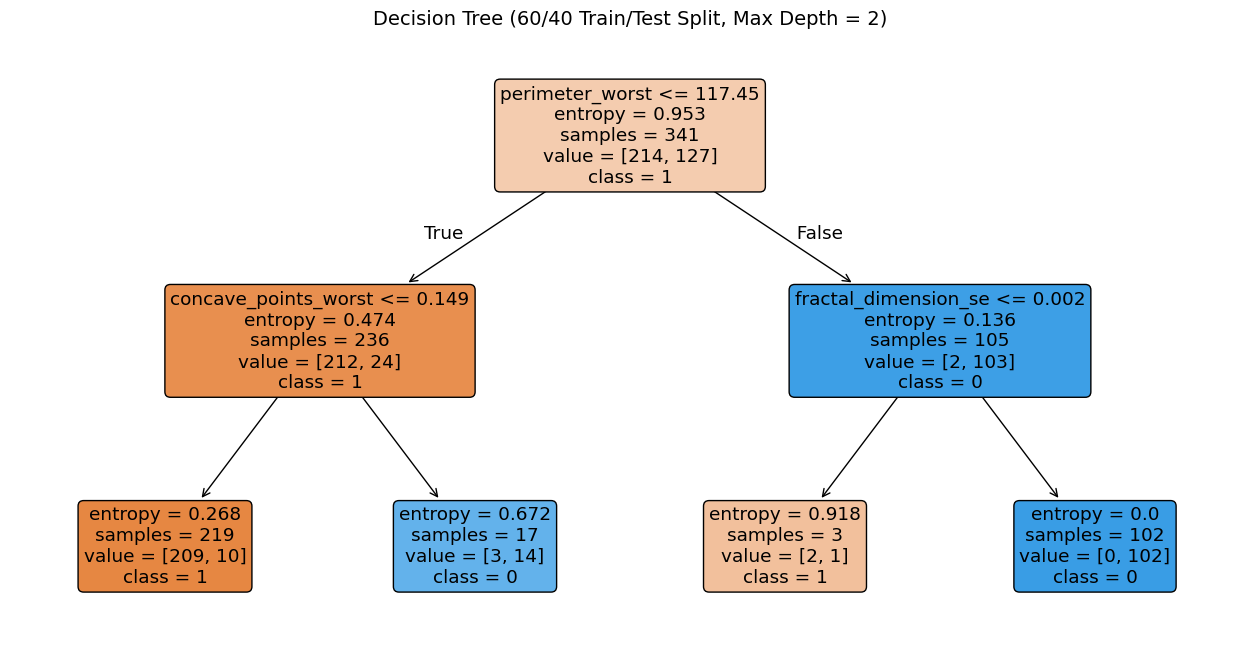

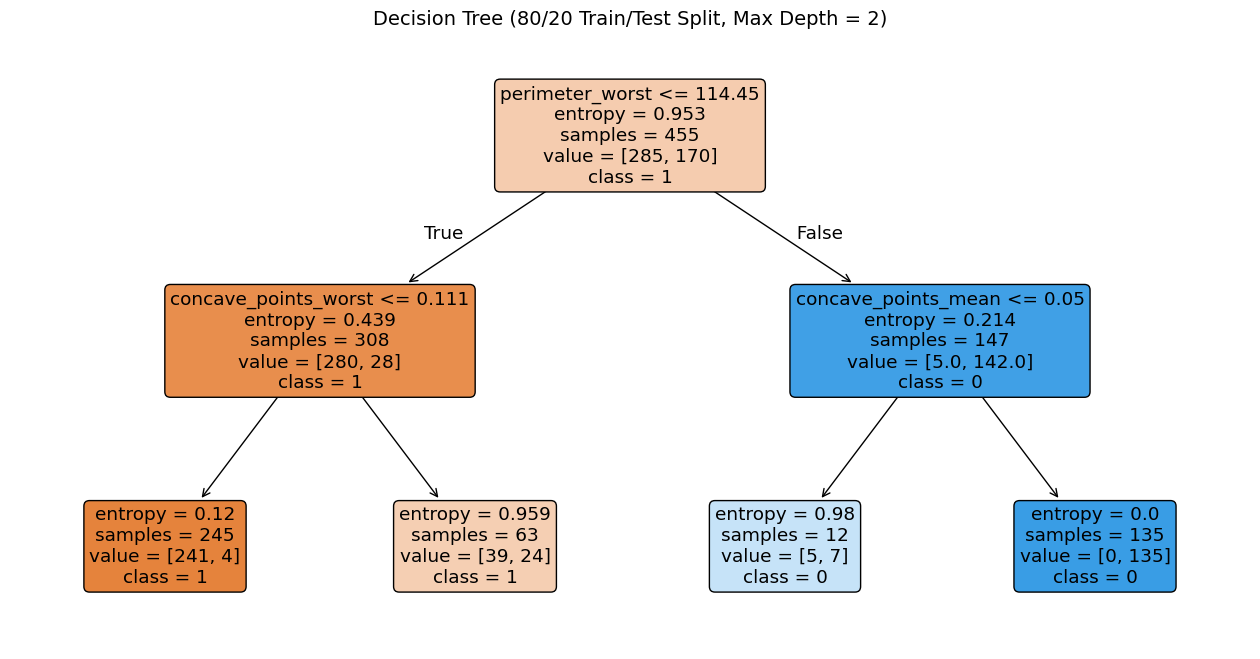

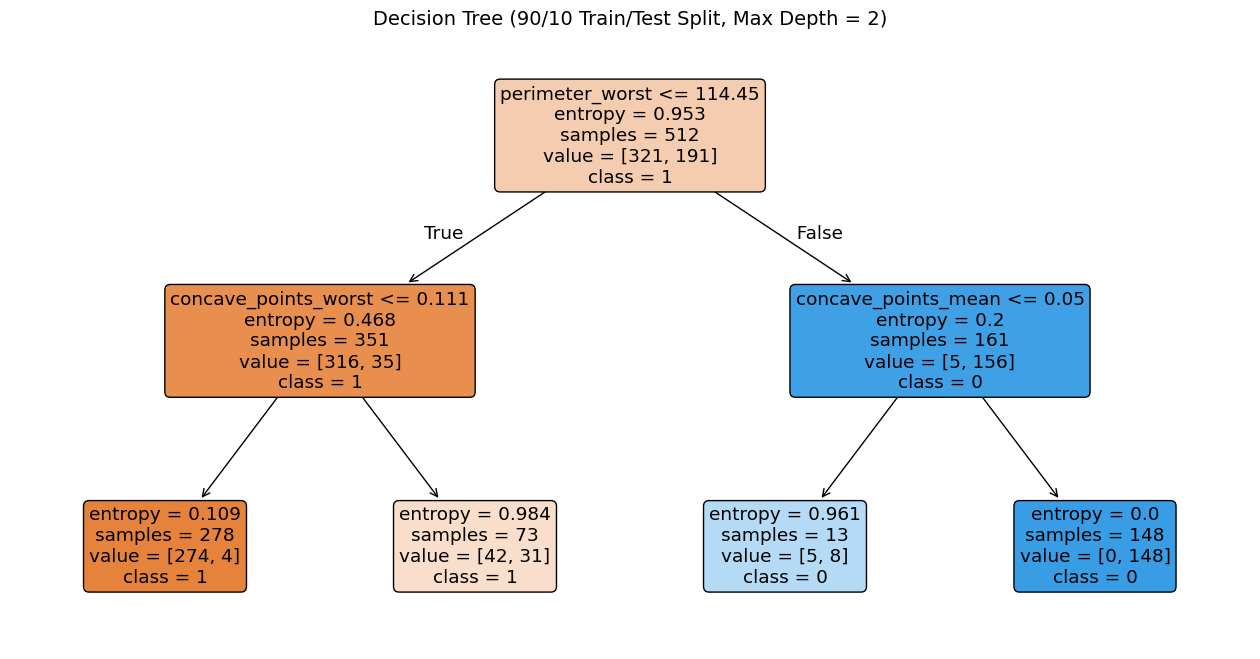

In [7]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

# Hàm xây dựng và trực quan hóa cây quyết định
def build_and_visualize_tree(X_train, y_train, train_size, test_size, max_depth=2):
    """
    Xây dựng và trực quan hóa cây quyết định.

    Args:
        X_train: Dữ liệu đặc trưng của tập huấn luyện.
        y_train: Dữ liệu nhãn của tập huấn luyện.
        train_size: Tỷ lệ tập huấn luyện.
        test_size: Tỷ lệ tập kiểm tra.
        max_depth: Độ sâu tối đa của cây quyết định.
    """
    clf = DecisionTreeClassifier(max_depth=max_depth, criterion='entropy', random_state=42)
    clf.fit(X_train, y_train)
    
    # Chuyển nhãn lớp sang dạng chuỗi
    class_names = [str(cls) for cls in y_train.unique()]
    
    # Trực quan hóa cây quyết định
    plt.figure(figsize=(16, 8))
    plot_tree(
        clf, 
        feature_names=X.columns, 
        class_names=class_names,  # Sử dụng nhãn lớp dưới dạng chuỗi
        filled=True, 
        rounded=True
    )
    plt.title(f"Decision Tree ({int(train_size*100)}/{int(test_size*100)} Train/Test Split, Max Depth = {max_depth})", fontsize=14)
    plt.show()

# Vẽ cây quyết định trên các tỷ lệ
split_ratios = [(0.4, 0.6), (0.6, 0.4), (0.8, 0.2), (0.9, 0.1)]
for train_size, test_size in split_ratios:
    # Lấy dữ liệu tương ứng với tỷ lệ hiện tại
    X_train, X_test, y_train, y_test = datasets[(train_size, test_size)]
    
    # Gọi hàm để vẽ cây quyết định
    build_and_visualize_tree(X_train, y_train, train_size, test_size, max_depth=2)



## 2.3.Đánh giá bộ phân loại cây quyết định


Evaluating Decision Tree for split 40/60:
Classification Report:
              precision    recall  f1-score   support

           B       0.91      0.96      0.93       215
           M       0.92      0.83      0.88       127

    accuracy                           0.91       342
   macro avg       0.91      0.90      0.90       342
weighted avg       0.91      0.91      0.91       342

Confusion Matrix:
[[206   9]
 [ 21 106]]


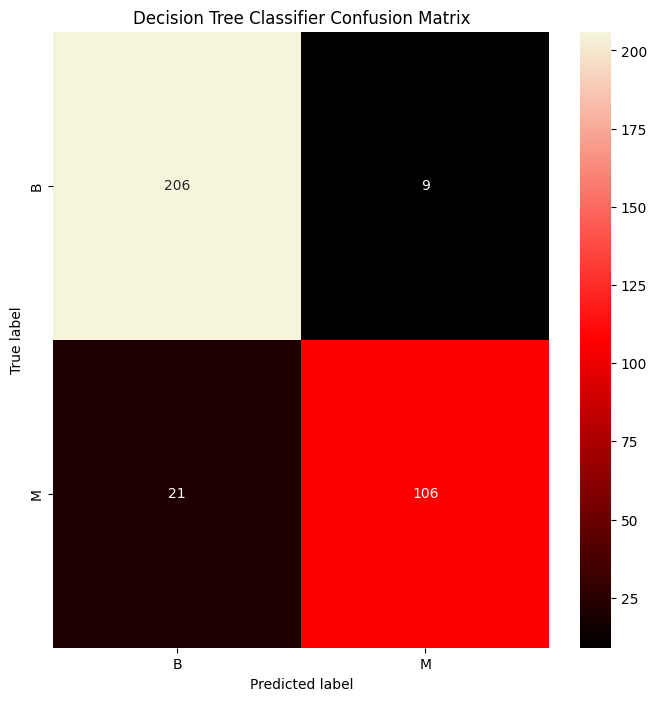


Evaluating Decision Tree for split 60/40:
Classification Report:
              precision    recall  f1-score   support

           B       0.94      0.96      0.95       143
           M       0.93      0.91      0.92        85

    accuracy                           0.94       228
   macro avg       0.94      0.93      0.93       228
weighted avg       0.94      0.94      0.94       228

Confusion Matrix:
[[137   6]
 [  8  77]]


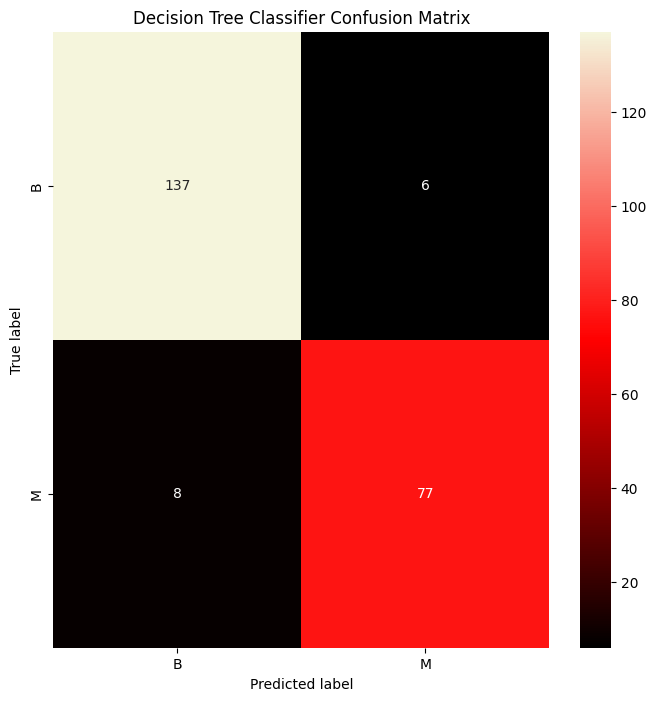


Evaluating Decision Tree for split 80/20:
Classification Report:
              precision    recall  f1-score   support

           B       0.95      0.99      0.97        72
           M       0.97      0.90      0.94        42

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114

Confusion Matrix:
[[71  1]
 [ 4 38]]


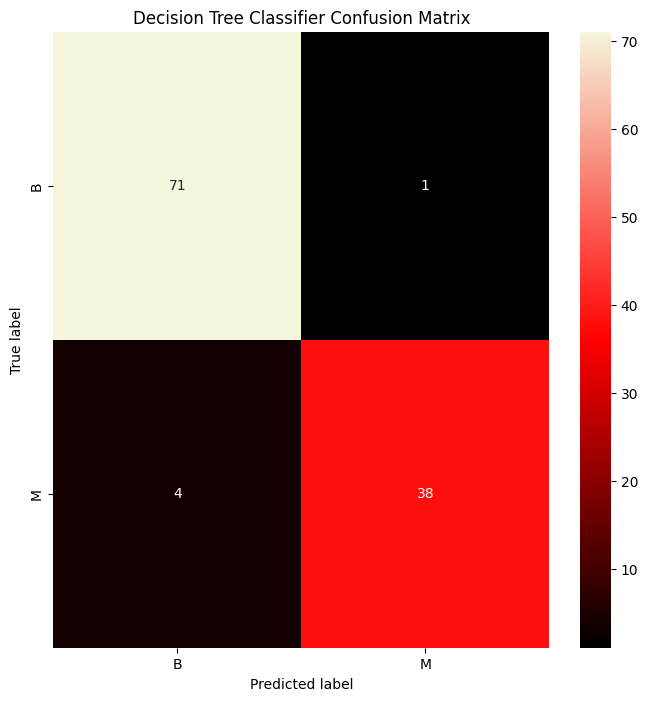


Evaluating Decision Tree for split 90/10:
Classification Report:
              precision    recall  f1-score   support

           B       0.95      0.97      0.96        36
           M       0.95      0.90      0.93        21

    accuracy                           0.95        57
   macro avg       0.95      0.94      0.94        57
weighted avg       0.95      0.95      0.95        57

Confusion Matrix:
[[35  1]
 [ 2 19]]


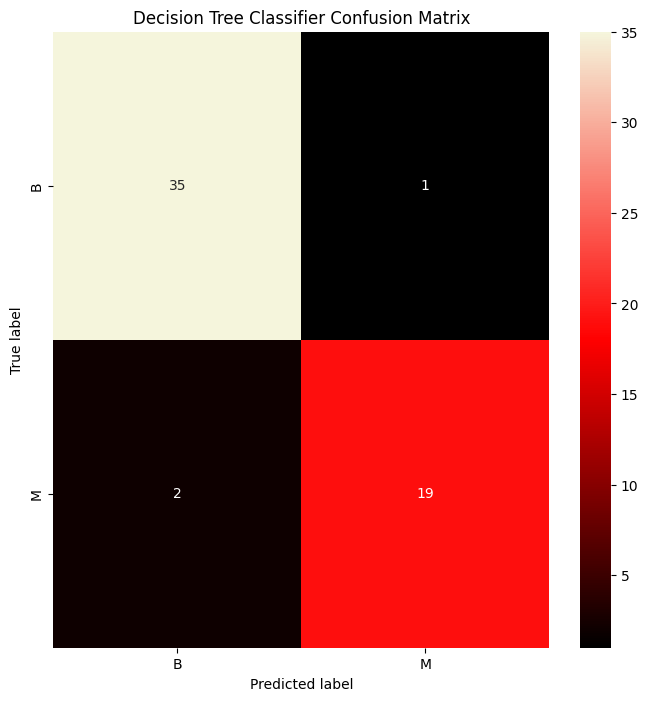

In [8]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
import matplotlib.colors as mcolors

# Chuyển đổi nhãn từ 0, 1 sang M, B
def map_labels(y):
    return y.replace({0: 'B', 1: 'M'})

# Hàm đánh giá hiệu suất mô hình
def evaluate_model(clf, X_test, y_test, label_classes):
    y_pred = clf.predict(X_test)
    
    # Báo cáo phân loại
    print("Classification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))
    
    # Ma trận nhầm lẫn
    print("Confusion Matrix:")
    cm = confusion_matrix(y_test, y_pred, labels=label_classes)
    print(cm)

    # Trực quan hóa ma trận nhầm lẫn
    cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", [(0, "black"), (0.5, "red"), (1, "beige")])
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, xticklabels=label_classes, yticklabels=label_classes)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Decision Tree Classifier Confusion Matrix')
    plt.show()

# Tỷ lệ chia train/test
split_ratios = [(0.4, 0.6), (0.6, 0.4), (0.8, 0.2), (0.9, 0.1)]

# Thực hiện đánh giá cho từng tỷ lệ
for train_size, test_size in split_ratios:
    print(f"\nEvaluating Decision Tree for split {int(train_size*100)}/{int(test_size*100)}:")
    
    # Lấy dữ liệu train/test từ datasets
    X_train, X_test, y_train, y_test = datasets[(train_size, test_size)]
    
    # Chuyển nhãn 0, 1 thành M, B
    y_train = map_labels(y_train)
    y_test = map_labels(y_test)
    
    # Huấn luyện mô hình
    clf = DecisionTreeClassifier(max_depth=None, criterion='entropy', random_state=42)
    clf.fit(X_train, y_train)
    
    # Đánh giá mô hình
    evaluate_model(clf, X_test, y_test, label_classes=['B', 'M'])



## 2.4.Độ Sâu và Độ Chính Xác của Cây Quyết Định (80/20)

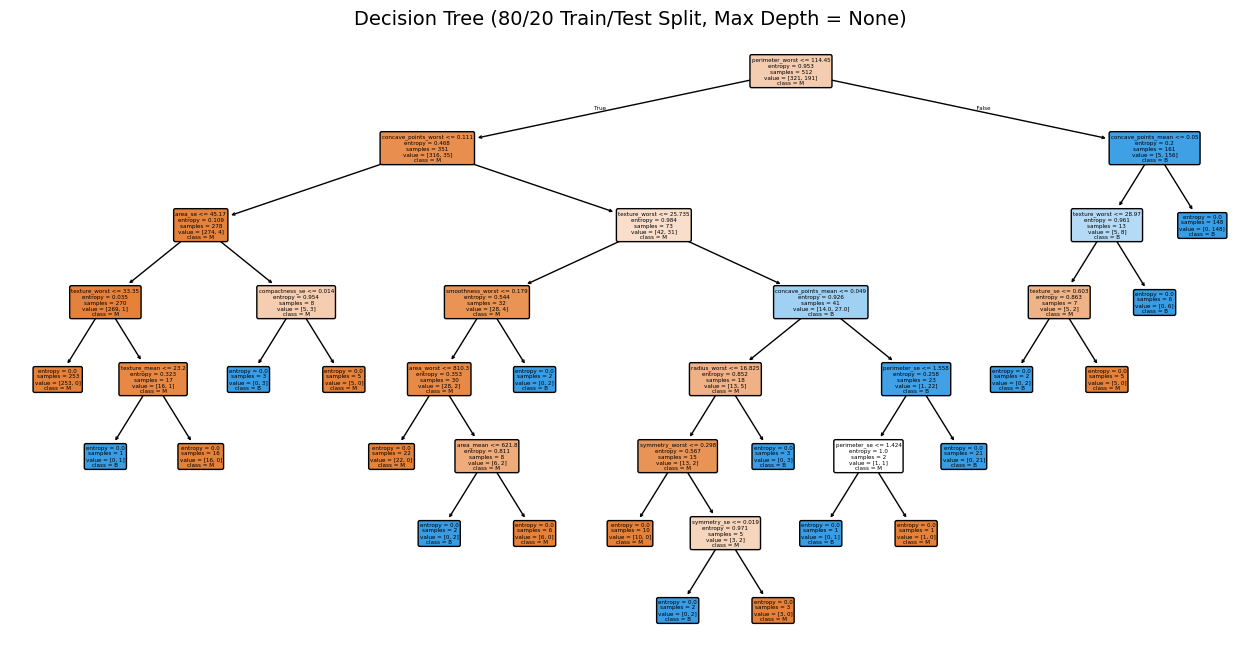

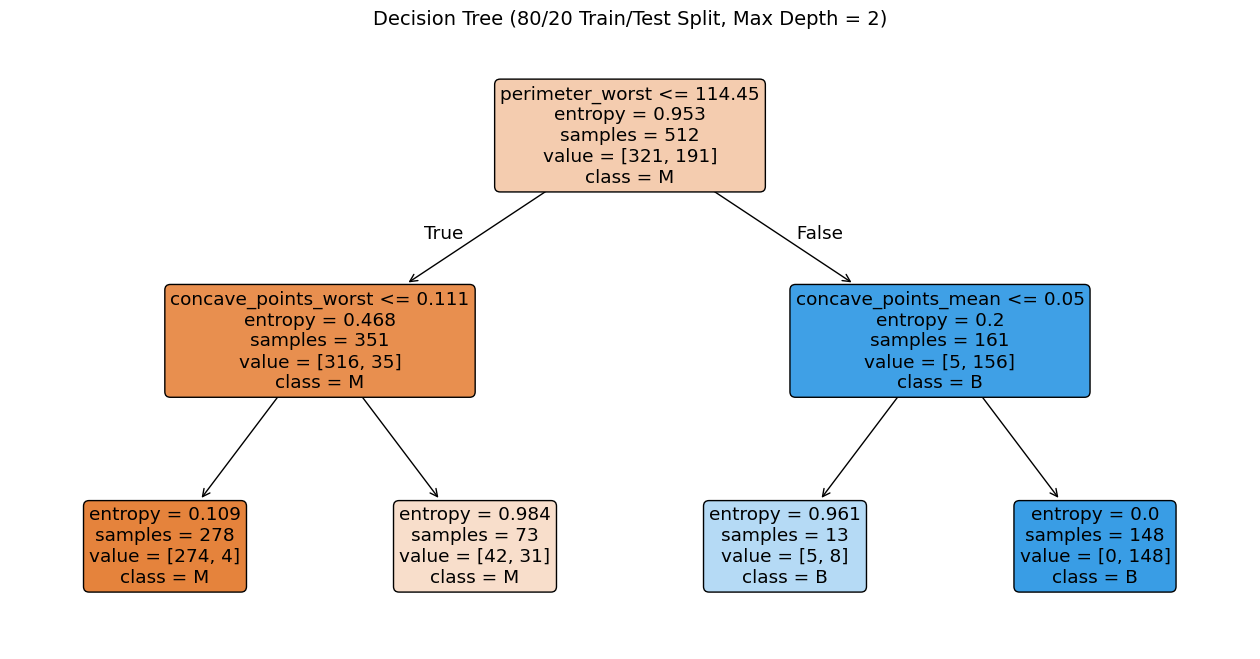

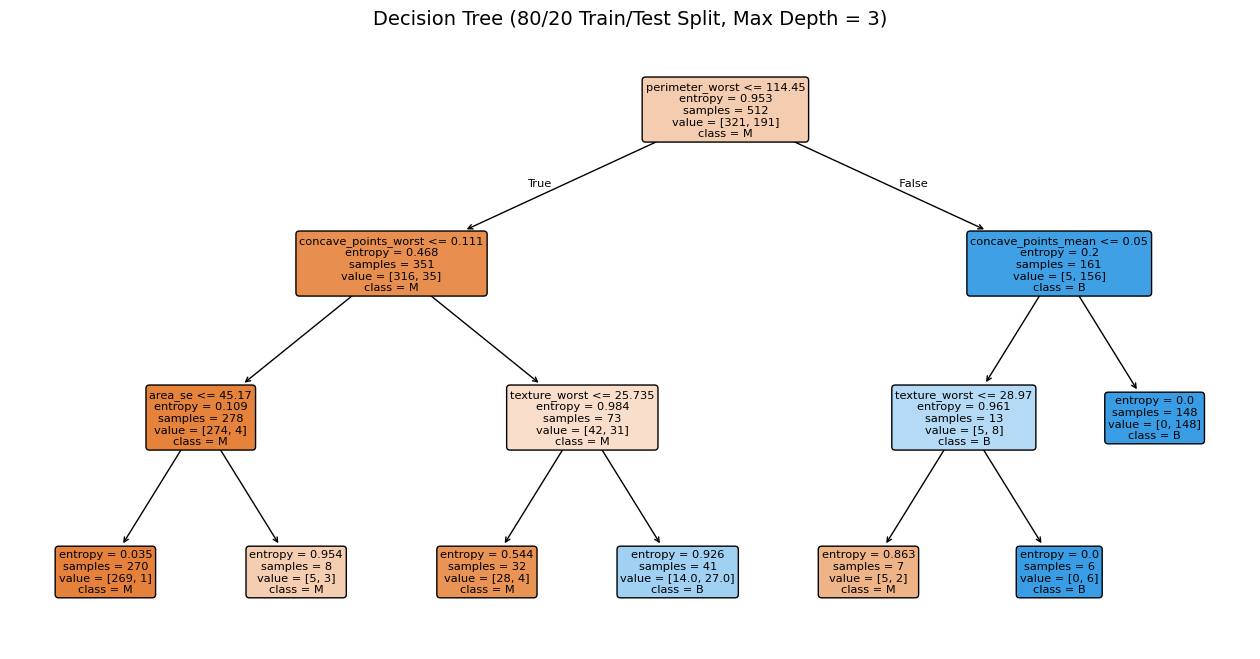

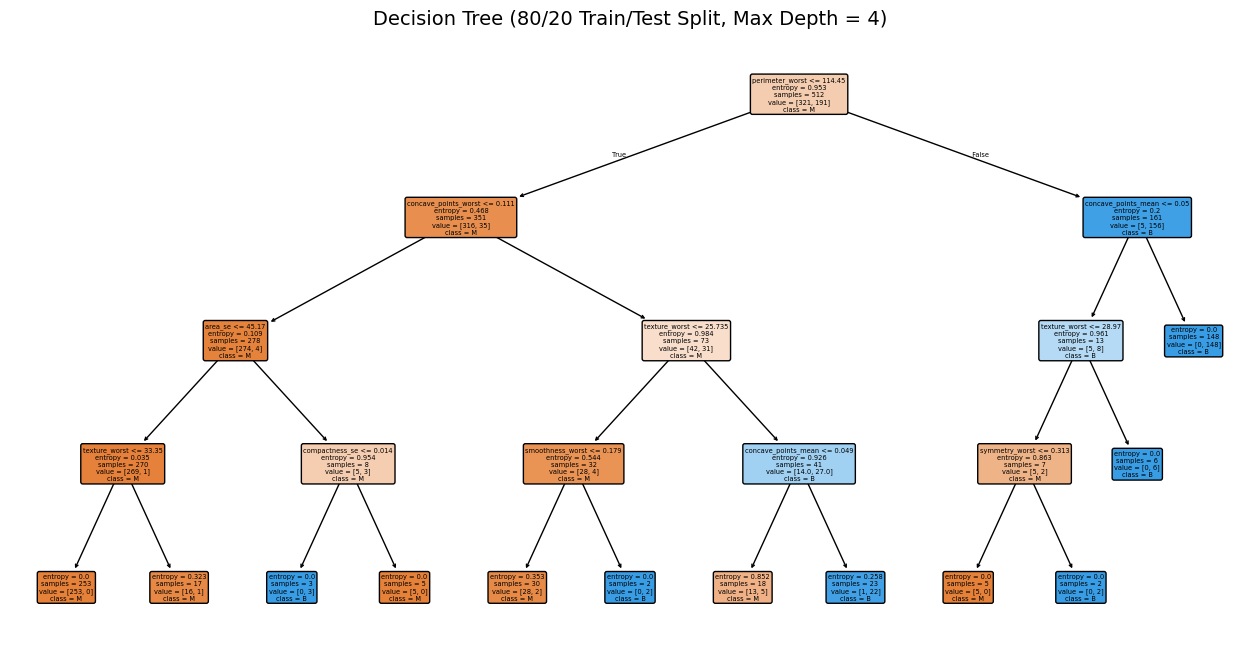

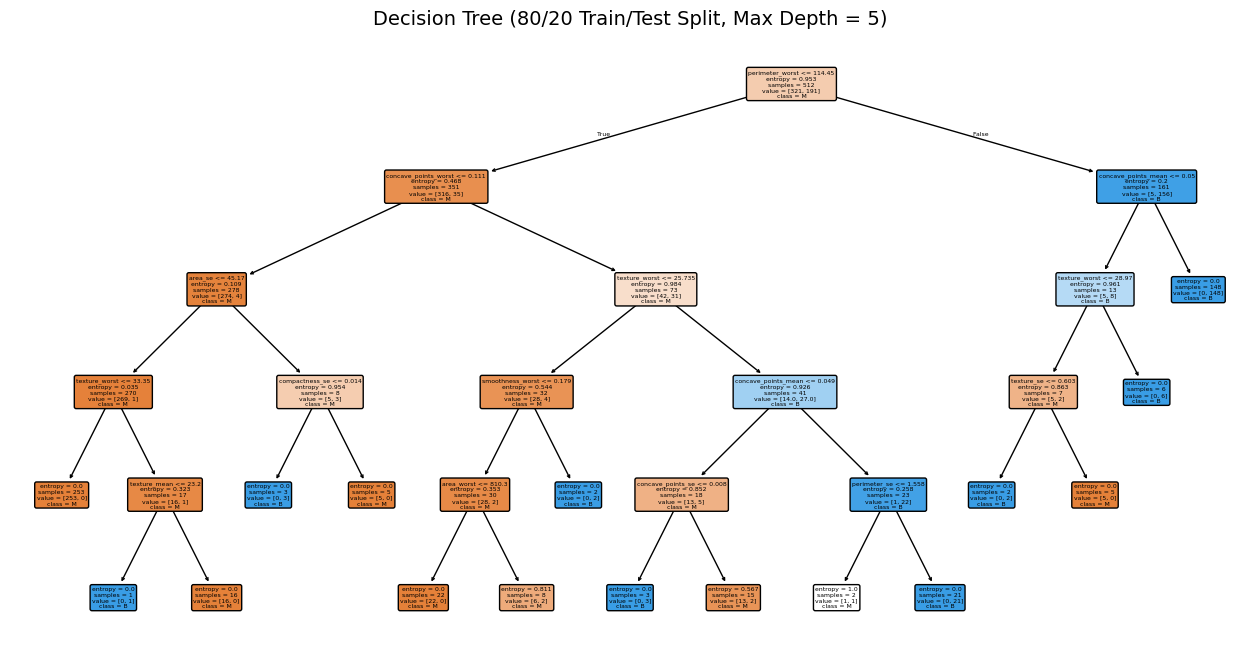

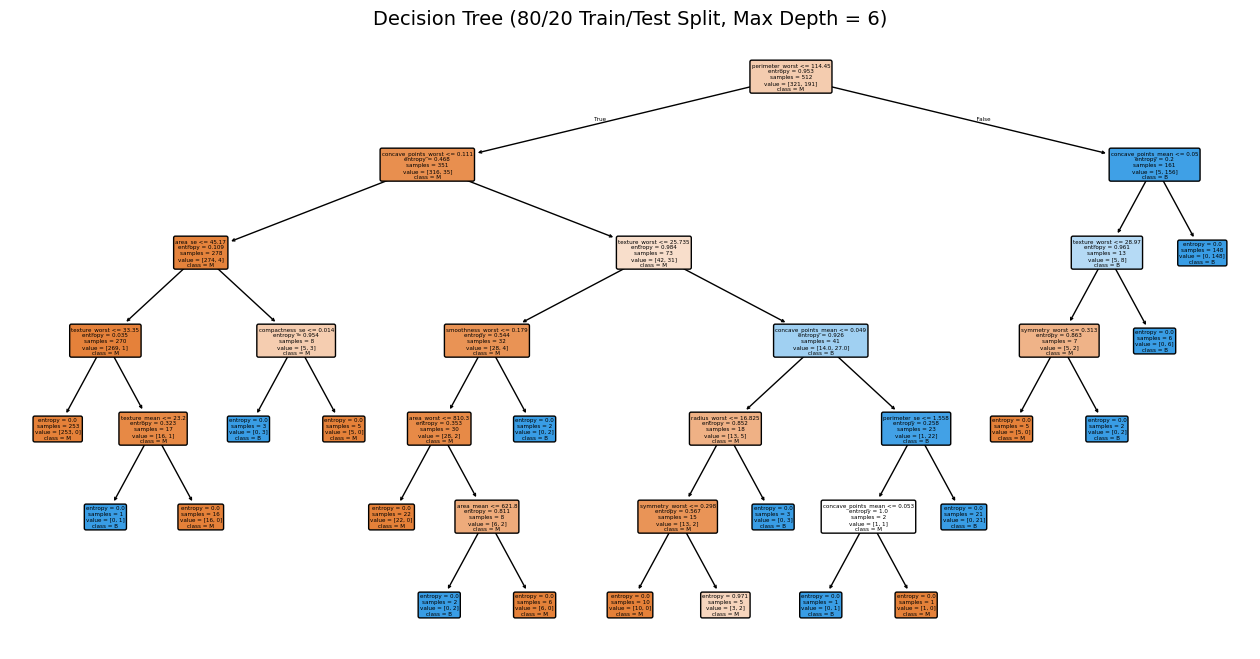

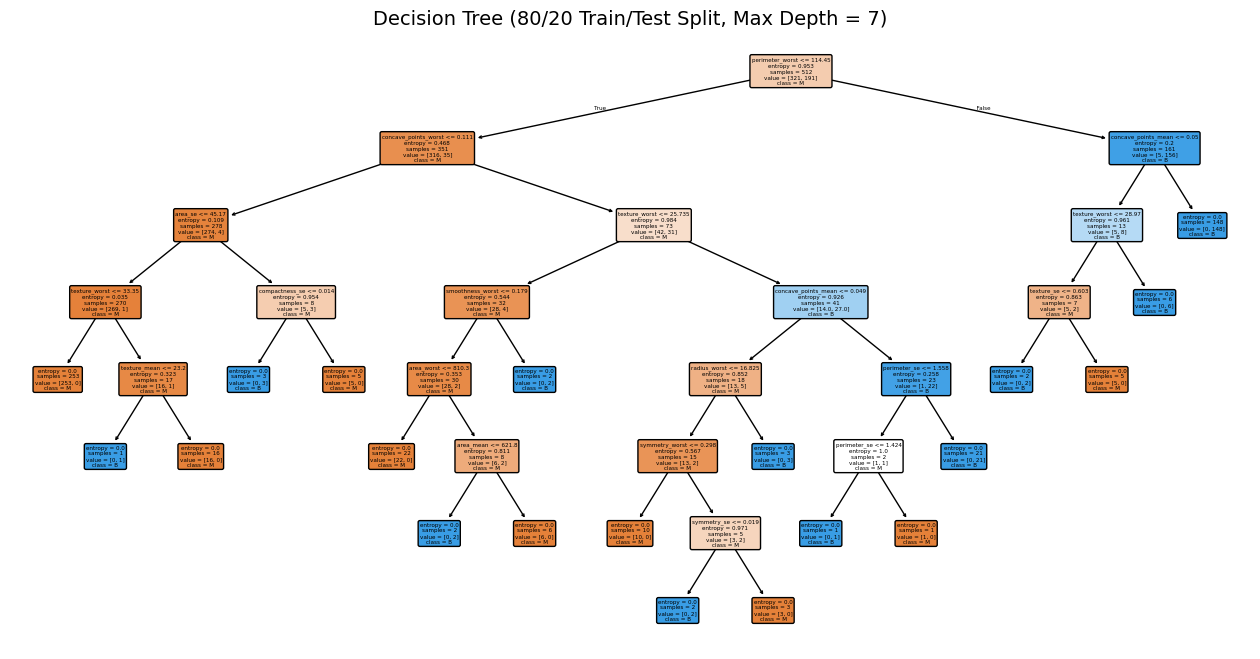

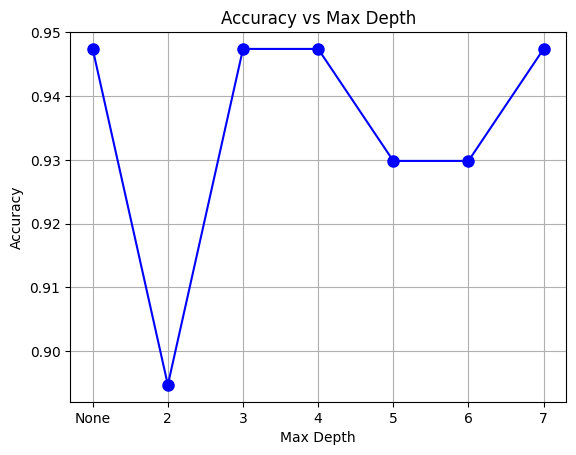


Accuracy for different max_depth values (Horizontal Format):
              None         2         3         4         5         6         7
Accuracy  0.947368  0.894737  0.947368  0.947368  0.929825  0.929825  0.947368


In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd

# Định nghĩa các độ sâu cần kiểm tra
depths = [None, 2, 3, 4, 5, 6, 7]
accuracies = []

# Tỷ lệ dữ liệu
train_size = 0.8
test_size = 0.2

# Duyệt qua các giá trị max_depth
for max_depth in depths:
    clf = DecisionTreeClassifier(max_depth=max_depth, criterion='entropy', random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
    
    # Trực quan hóa cây
    build_and_visualize_tree(X_train, y_train, train_size=train_size, test_size=test_size, max_depth=max_depth)

# Tạo nhãn trục x cho biểu đồ
x_labels = ['None' if d is None else str(d) for d in depths]

# Vẽ biểu đồ Accuracy vs Max Depth
plt.plot(x_labels, accuracies, marker='o', color='b', linestyle='-', markersize=8)
plt.title('Accuracy vs Max Depth')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.xticks(x_labels)
plt.grid(True)
plt.show()

# Tạo bảng kết quả với giá trị nằm ngang
accuracy_df_horizontal = pd.DataFrame([accuracies], columns=x_labels)
accuracy_df_horizontal.index = ['Accuracy']

# In bảng kết quả theo chiều ngang
print("\nAccuracy for different max_depth values (Horizontal Format):")
print(accuracy_df_horizontal.to_string(index=True, header=True))


# 3.Tóm tắt kết quả

In [10]:
results = {
    "Number of Classes": [y.nunique()],
    "Number of Features": [X.shape[1]],
    "Sample Size": [X.shape[0]],
    "Accuracy": [accuracy]
}

results_df = pd.DataFrame(results)
print("Dataset Summary:")
print(results_df)

Dataset Summary:
   Number of Classes  Number of Features  Sample Size  Accuracy
0                  2                  30          569  0.947368
